In [1]:
import pandas as pd
import os
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch, Pitch
from highlight_text import ax_text, fig_text
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
import pandas as pd
folder = 'Data'
archivo = 'WhoScoredTeamPerMatchSpatial8x6TimeDiv45.csv'

path = os.path.join(folder, archivo)

m1 = pd.read_csv(path)

In [3]:
m1.tail()

,Unnamed: 0,Team,Date,Goals,game_id,Pass_Successful_bin_0_time_0-45,Pass_Unsuccessful_bin_0_time_0-45,Pass_Successful_bin_1_time_0-45,Pass_Unsuccessful_bin_1_time_0-45,Pass_Successful_bin_2_time_0-45,...,Error_Successful_bin_43_time_45-90,Error_Unsuccessful_bin_43_time_45-90,Error_Successful_bin_44_time_45-90,Error_Unsuccessful_bin_44_time_45-90,Error_Successful_bin_45_time_45-90,Error_Unsuccessful_bin_45_time_45-90,Error_Successful_bin_46_time_45-90,Error_Unsuccessful_bin_46_time_45-90,Error_Successful_bin_47_time_45-90,Error_Unsuccessful_bin_47_time_45-90
45931,0,Monaco,2024-02-25,2,1741135,0.0,1.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45932,0,Le Havre,2024-02-25,1,1741137,2.0,1.0,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45933,0,Reims,2024-02-25,2,1741137,1.0,2.0,5.0,7.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45934,0,Rennes,2024-02-25,1,1741159,0.0,0.0,5.0,3.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45935,0,PSG,2024-02-25,1,1741159,0.0,0.0,3.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
columnas = ["game_id", "Date", "Team1", "Team2", "Goals1", "Goals2"]
new_stats = ["wins",
"ties",
"losses",
"total_goals",
"total_goals_conceded",
"points",
"streak",
"wins_in_last_5_matches",
"ties_in_last_5_matches",
"losses_in_last_5_matches"]

stats = m1.columns[6:] # Columnas de estadísticas

for stat in new_stats:
    columnas.append(f"{stat}_1")
    columnas.append(f"{stat}_2")

for stat in stats:
    columnas.append(f"{stat}_1")
    columnas.append(f"{stat}_2")


Creación de tabla con información

In [5]:
tabla = {}
equipos = m1["Team"].unique()

datos = new_stats + list(stats)
for equipo in equipos:

    tabla[equipo] = dict.fromkeys(datos, 0)
    tabla[equipo]["last_5_matches"] = list()
    tabla[equipo]["partidos"] = 0
    tabla[equipo]["id_hace_15"] = 0

In [6]:
tabla["Lorient"].keys()

dict_keys(['wins', 'ties', 'losses', 'total_goals', 'total_goals_conceded', 'points', 'streak', 'wins_in_last_5_matches', 'ties_in_last_5_matches', 'losses_in_last_5_matches', 'Pass_Unsuccessful_bin_0_time_0-45', 'Pass_Successful_bin_1_time_0-45', 'Pass_Unsuccessful_bin_1_time_0-45', 'Pass_Successful_bin_2_time_0-45', 'Pass_Unsuccessful_bin_2_time_0-45', 'Pass_Successful_bin_3_time_0-45', 'Pass_Unsuccessful_bin_3_time_0-45', 'Pass_Successful_bin_4_time_0-45', 'Pass_Unsuccessful_bin_4_time_0-45', 'Pass_Successful_bin_5_time_0-45', 'Pass_Unsuccessful_bin_5_time_0-45', 'Pass_Successful_bin_6_time_0-45', 'Pass_Unsuccessful_bin_6_time_0-45', 'Pass_Successful_bin_7_time_0-45', 'Pass_Unsuccessful_bin_7_time_0-45', 'Pass_Successful_bin_8_time_0-45', 'Pass_Unsuccessful_bin_8_time_0-45', 'Pass_Successful_bin_9_time_0-45', 'Pass_Unsuccessful_bin_9_time_0-45', 'Pass_Successful_bin_10_time_0-45', 'Pass_Unsuccessful_bin_10_time_0-45', 'Pass_Successful_bin_11_time_0-45', 'Pass_Unsuccessful_bin_11_tim

In [7]:
matches_columns = columnas
matches = pd.DataFrame(columns=matches_columns)
matches

,game_id,Date,Team1,Team2,Goals1,Goals2,wins_1,wins_2,ties_1,ties_2,...,Error_Unsuccessful_bin_45_time_45-90_1,Error_Unsuccessful_bin_45_time_45-90_2,Error_Successful_bin_46_time_45-90_1,Error_Successful_bin_46_time_45-90_2,Error_Unsuccessful_bin_46_time_45-90_1,Error_Unsuccessful_bin_46_time_45-90_2,Error_Successful_bin_47_time_45-90_1,Error_Successful_bin_47_time_45-90_2,Error_Unsuccessful_bin_47_time_45-90_1,Error_Unsuccessful_bin_47_time_45-90_2


In [8]:
m1 = m1[m1["Date"] > "2022-08-01"]

In [9]:

contador = 0
for game_id in tqdm(m1['game_id'].unique(), desc="Processing games"):
    fila = []
    game = m1[m1['game_id'] == game_id]
    fila.append(game_id)
    fila.append(game['Date'].values[0])
    fila.append(game['Team'].values[0])
    fila.append(game['Team'].values[1])
    fila.append(game['Goals'].values[0])
    fila.append(game['Goals'].values[1])

    team_1 = game['Team'].values[0]
    team_2 = game['Team'].values[1]

    for stat in new_stats:
        fila.append(tabla[team_1][stat])
        fila.append(tabla[team_2][stat])

    for stat in stats:
        fila.append(tabla[team_1][stat])
        fila.append(tabla[team_2][stat])

    matches.loc[len(matches)] = fila

    "Relleno de stats"

    for stat in stats:
        if tabla[team_1]["partidos"] < 15:
            tabla[team_1][stat] += game[stat].values[0]
        if tabla[team_2]["partidos"] < 15:
            tabla[team_2][stat] += game[stat].values[1]
        if tabla[team_1]["partidos"] >= 15:
            tabla[team_1][stat] += game[stat].values[0] - m1[m1["game_id"]==tabla[team_1]["id_hace_15"]][stat].values[0]
            if tabla[team_1][stat] < 0:
                tabla[team_1][stat] = 0
        if tabla[team_2]["partidos"] >= 15:
            tabla[team_2][stat] += game[stat].values[1] - m1[m1["game_id"]==tabla[team_2]["id_hace_15"]][stat].values[0]
            if tabla[team_2][stat] < 0:
                tabla[team_2][stat] = 0

    tabla[team_1]["partidos"] += 1
    tabla[team_2]["partidos"] += 1

    if tabla[team_1]["partidos"] >= 15:
        tabla[team_1]["id_hace_15"] = game_id
    if tabla[team_2]["partidos"] >= 15:
        tabla[team_2]["id_hace_15"] = game_id

    

    # Rellenar stats acumuladas

    empate = False

    if game['Goals'].values[0] > game['Goals'].values[1]:

        tabla[team_1]["wins"] += 1
        tabla[team_2]["losses"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_1]["points"] += 3

        tabla[team_1]["streak"] += 1
        tabla[team_2]["streak"] = 0

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("W")
        tabla[team_2]["last_5_matches"].append("L")

    elif game['Goals'].values[0] < game['Goals'].values[1]:

        tabla[team_2]["wins"] += 1
        tabla[team_1]["losses"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_2]["points"] += 3

        tabla[team_2]["streak"] += 1
        tabla[team_1]["streak"] = 0

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("L")
        tabla[team_2]["last_5_matches"].append("W")

    else:

        tabla[team_1]["ties"] += 1
        tabla[team_2]["ties"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_1]["points"] += 1
        tabla[team_2]["points"] += 1

        tabla[team_1]["streak"] += 1
        tabla[team_2]["streak"] += 1

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("T")
        tabla[team_2]["last_5_matches"].append("T")
    
    tabla[team_1]["wins_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("W")
    tabla[team_1]["ties_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("T")
    tabla[team_1]["losses_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("L")

    tabla[team_2]["wins_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("W")
    tabla[team_2]["ties_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("T")
    tabla[team_2]["losses_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("L")


Processing games: 100%|██████████| 2985/2985 [2:37:21<00:00,  3.16s/it]  


In [10]:
matches.tail()


,game_id,Date,Team1,Team2,Goals1,Goals2,wins_1,wins_2,ties_1,ties_2,...,Error_Unsuccessful_bin_45_time_45-90_1,Error_Unsuccessful_bin_45_time_45-90_2,Error_Successful_bin_46_time_45-90_1,Error_Successful_bin_46_time_45-90_2,Error_Unsuccessful_bin_46_time_45-90_1,Error_Unsuccessful_bin_46_time_45-90_2,Error_Successful_bin_47_time_45-90_1,Error_Successful_bin_47_time_45-90_2,Error_Unsuccessful_bin_47_time_45-90_1,Error_Unsuccessful_bin_47_time_45-90_2
2980,1741127,2024-02-25,Lille,Toulouse,1,3,30,19,19,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2981,1741133,2024-02-25,Nice,Clermont Foot,0,0,24,20,21,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2982,1741135,2024-02-25,Lens,Monaco,3,2,34,31,15,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,1741137,2024-02-25,Le Havre,Reims,1,2,5,20,9,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2984,1741159,2024-02-25,Rennes,PSG,1,1,31,41,13,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ML

In [11]:
matches2 = matches.copy()

In [12]:
results = []

for index in matches.index:

    match = matches.loc[index]
    if match["Goals1"] > match["Goals2"]:
        results.append(1)
    elif match["Goals1"] < match["Goals2"]:
        results.append(2)
    else:
        results.append(0)

matches["result"] = results

In [13]:
for i in range(0,3):
    cantidad = matches[matches["result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos, {cantidad*100/len(matches)}%")

Resultado 0, hay: 758 partidos, 25.393634840871023%
Resultado 1, hay: 1246 partidos, 41.74204355108878%
Resultado 2, hay: 981 partidos, 32.8643216080402%


In [14]:
result = matches["result"]
matches = matches.drop(columns = ["game_id", "Date", "Team1", "Team2", "Goals1", "Goals2", "result"])

In [15]:
matches

,wins_1,wins_2,ties_1,ties_2,losses_1,losses_2,total_goals_1,total_goals_2,total_goals_conceded_1,total_goals_conceded_2,...,Error_Unsuccessful_bin_45_time_45-90_1,Error_Unsuccessful_bin_45_time_45-90_2,Error_Successful_bin_46_time_45-90_1,Error_Successful_bin_46_time_45-90_2,Error_Unsuccessful_bin_46_time_45-90_1,Error_Unsuccessful_bin_46_time_45-90_2,Error_Successful_bin_47_time_45-90_1,Error_Successful_bin_47_time_45-90_2,Error_Unsuccessful_bin_47_time_45-90_1,Error_Unsuccessful_bin_47_time_45-90_2
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,30,19,19,17,11,24,100,75,58,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2981,24,20,21,15,15,25,68,61,54,85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2982,34,31,15,11,11,18,95,114,51,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,5,20,9,19,8,21,24,74,27,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X = matches.to_numpy()
scaler = preprocessing.StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result

In [17]:
y.unique()

array([0, 1, 2], dtype=int64)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_escalados, y, test_size=0.3, random_state = 1, stratify=y)

# Modelo 1: Regresión Logística

In [19]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter = 1000)
logistic_reg.fit(X_train, y_train)

predicted_logistic_reg = logistic_reg.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_logistic_reg))

Clasification report
              precision    recall  f1-score   support

           0       0.25      0.21      0.23       228
           1       0.52      0.54      0.53       374
           2       0.39      0.41      0.40       294

    accuracy                           0.42       896
   macro avg       0.39      0.39      0.39       896
weighted avg       0.41      0.42      0.41       896



In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


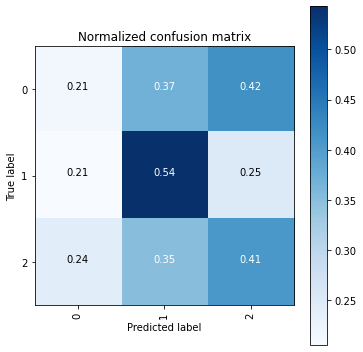

In [24]:
cnf_matrix = confusion_matrix(y_test, predicted_logistic_reg)
np.set_printoptions(precision=2)
classes = np.unique(y)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## SVM

In [21]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel = kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        f"For kernel = {kernel}, the accuracy is: {acc}"
    )


For kernel = linear, the accuracy is: 0.41294642857142855
For kernel = poly, the accuracy is: 0.44308035714285715
For kernel = rbf, the accuracy is: 0.48995535714285715
For kernel = sigmoid, the accuracy is: 0.48549107142857145


In [22]:
from sklearn.svm import SVC

svm = SVC(kernel = "rbf")

svm.fit(X_train, y_train)

predicted_svm = svm.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_svm))

Clasification report
              precision    recall  f1-score   support

           0       0.24      0.06      0.10       228
           1       0.51      0.79      0.62       374
           2       0.50      0.44      0.47       294

    accuracy                           0.49       896
   macro avg       0.42      0.43      0.40       896
weighted avg       0.44      0.49      0.44       896



Normalized confusion matrix


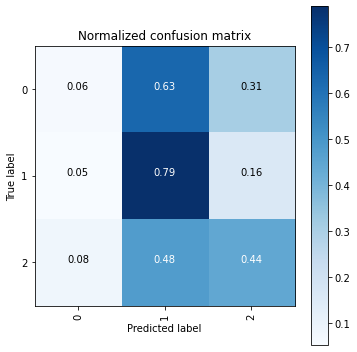

In [25]:
cnf_matrix = confusion_matrix(y_test, predicted_svm)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

range_T = [50, 100, 200, 500, 1000]


for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=50, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 50 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=20, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 20 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=10, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 10 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=5, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


For min_samples_split = 50 and t = 50 The accuracy is : 0.5100446428571429
For min_samples_split = 50 and t = 100 The accuracy is : 0.5100446428571429
For min_samples_split = 50 and t = 200 The accuracy is : 0.49888392857142855
For min_samples_split = 50 and t = 500 The accuracy is : 0.4966517857142857
For min_samples_split = 50 and t = 1000 The accuracy is : 0.5011160714285714
For min_samples_split = 20 and t = 50 The accuracy is : 0.48660714285714285
For min_samples_split = 20 and t = 100 The accuracy is : 0.49330357142857145
For min_samples_split = 20 and t = 200 The accuracy is : 0.5022321428571429
For min_samples_split = 20 and t = 500 The accuracy is : 0.5033482142857143
For min_samples_split = 20 and t = 1000 The accuracy is : 0.5033482142857143
For min_samples_split = 10 and t = 50 The accuracy is : 0.48995535714285715
For min_samples_split = 10 and t = 100 The accuracy is : 0.5033482142857143
For min_samples_split = 10 and t = 200 The accuracy is : 0.49441964285714285
For min_

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split=50, n_estimators=50, random_state=0)

rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_rf))

Clasification report
              precision    recall  f1-score   support

           0       0.37      0.07      0.12       228
           1       0.52      0.78      0.63       374
           2       0.51      0.51      0.51       294

    accuracy                           0.51       896
   macro avg       0.47      0.45      0.42       896
weighted avg       0.48      0.51      0.46       896



Normalized confusion matrix


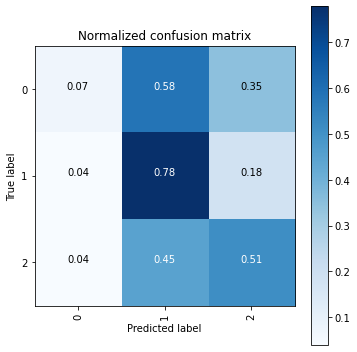

In [28]:
cnf_matrix = confusion_matrix(y_test, predicted_rf)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7), n_estimators=1000, random_state=0)

ada.fit(X_train, y_train)

predicted_ada = ada.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_ada))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_ada)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =3, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =4, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =5, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =6, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =7, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =8, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


In [ ]:
gb = GradientBoostingClassifier(n_estimators=200, max_depth =8, random_state=0)

gb.fit(X_train, y_train)

predicted_gb = gb.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_gb))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_gb)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## XGboost

In [ ]:
from xgboost import XGBClassifier


range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =3, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =4, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =5, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =6, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =7, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =8, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

In [ ]:
xgb = XGBClassifier(max_depth = 6, n_estimators = 100)

xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_xgb))


In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_xgb)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## MLP

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Embedding, Concatenate
from tensorflow.keras.models import Model

mlp = Sequential([
    Input(shape = X_train[0].shape[0]),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation= "relu"),
    Dense(3, activation = "softmax")
])

mlp.summary()

In [83]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # Conjunto de validación = 0.8*0.25 = 0.2, este valor es estándar para validación

y_train2 = keras.utils.to_categorical(y_train2, 3)
y_val = keras.utils.to_categorical(y_val, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [ ]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Ajusta la función de pérdida según el tipo de problema categorical es para multi clases
mlp.fit(X_train2, y_train2, batch_size=32, epochs=20, validation_data=(X_val, y_val))

In [ ]:
predicted_mlp = mlp.predict(X_test)
predicted_mlp = [np.argmax(x) for x in predicted_mlp]
y_test = [np.argmax(x) for x in y_test]

In [ ]:
print("Clasification report")
print(classification_report(y_test, predicted_mlp))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_mlp)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()